# Face Recognition With Deep Learning

Rico Steinke, 196949, Heilbronn University, rsteinke@stud.hs-heilbronn.de

The project task is to 'create a neural network to recognize your face and clearly discern it from other faces and objects'. Therefore a dataset specifically for this task should be created. Also transfer learning techniques should be used with the restriction that the VGG architecture may not be used. For this purpose, the procedure for creating a data set is shown first. Then, the preprocessing of the data for the use in training a neural network. Finally, the results of the training will be shown and evaluated.
The notebook comes with a file 'condatf.yml' which can be used to create a conda environment that is able to run this notebook. Every cited source is listed in the [Bibliography](#Bibliography) at the end of the notebook.

### Imports
Import the required packages to execute this jupyter notebook and check if a GPU is available for training.

In [54]:
import datetime
import glob
import os.path
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shutil
import seaborn as sns
import ipywidgets as wg
from IPython.display import display
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.1
GPU is available


# Data Preparation

### Creating a dataset

- Vorgehen mit OpenCV beschreiben
- Random faces database zitieren <cite id="n544u"><a href="#zotero%7C12668441%2FAN5HZ4B7">(Huang et al., 2007)</a></cite>

#### Constants
First of all a couple of constants are defined to specify the directories which contain the unprocessed image data. Additionally an image size in pixels is defined to compute the images to this size later on. Also the batch size is defined to control how many samples are used in each epoch.

In [55]:
# constants
IMAGES_PATH = "images/"
DATASET_PATH = "dataset/"
DATASET_ME_PATH = DATASET_PATH + "me"
DATASET_SE_PATH = DATASET_PATH + "se"
DATASET_RO_PATH = DATASET_PATH + "ro"
IMAGES_ME_PATH = IMAGES_PATH + "me"
IMAGES_SE_PATH = IMAGES_PATH + "se"
IMAGES_RO_PATH = IMAGES_PATH + "ro"
IMAGES_SE_INPUTPATH = IMAGES_SE_PATH + "/*/*/*"
IMG_SIZE = 224
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2

To create a dataset to recognize my own face and clearly discern it from other faces it is necessary to get as much pictures of my face as possible. Furthermore different faces are needed. First it is dealt with getting pictures of myself. To achieve this private pictures from my phone and webcam recordings are saved. Secondly OpenCV <cite id="mofvs"><a href="#zotero%7C12668441%2FEXM36PCP">(Bradski, 2000)</a></cite> is used to detect faces in the pictures. This is especially useful to localize a region of interest if the picture contains multiple faces. The cropped images are getting sorted by hand and saved. This step is already done and does not need to be computed to run this notebook. If you still want to perform this step, it is recommended to use an alternative IDE with an integrated terminal and copy this cell to it to simplify the user input.

In [3]:
# make cell not executable
%%script false

import cv2 as cv

# get images from data path
images = [cv.imread(file) for file in glob.glob(f"{IMAGES_PATH}preDetection/*")]
# convert the images to grayscale
images_gray = [cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images]
# using cascade classifier for general face detection
cascade = cv.CascadeClassifier(r"files\haarcascade_frontalface_default.xml")
# detect faces
faces = [
    cascade.detectMultiScale(img_gray, scaleFactor=1.3, minNeighbors=5, minSize=(100, 100))
    for img_gray in images_gray
]

# loop over images list
j = 0
k = 0
for i, img in enumerate(images):
    for x, y, width, height in faces[i]:
        # crop image at ROI
        crop_image = img[y : y + height, x : x + width]
        # show image for manual validation
        cv.imshow("cropped image", crop_image)
        cv.waitKey(0)
        cv.destroyAllWindows()
        # ask user to sort image
        print(
            "Press 'm' if the picture shows your face. "
            "Press 's' if the picture shows something or somebody else. "
            "Press 'q' if you don't want to save the picture"
        )
        decision = input()
        if decision == "m":
            saved = cv.imwrite(f"{IMAGES_PATH}me/me_{j}.jpg", crop_image)
            if saved:
                print(f"saved to {IMAGES_PATH}me/me_{j}.jpg")
            j += 1
        elif decision == "s":
            saved = cv.imwrite(f"{IMAGES_SE_PATH}/se_{k}.jpg", crop_image)
            if saved:
                print(f"saved to {IMAGES_SE_PATH}/se_{k}.jpg")
            k += 1

UsageError: Line magic function `%%script` not found.


# ZELLE UNTEN AKTUALISIEREN

#### Folder structure
The root folder of this project contains the dataset in the *images*-directory and a *preDetection*-directory which contains the private images before labeling them manually as it is described in the step before. The *me*-directory contains images of my face and the *se*-directory contains images of somebody/something else. Those are the directories which are used to create the dataset described in the next step.

**BILD AKTUALISIEREN**

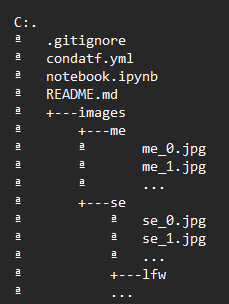

The folder structure used in this project work. Use *'tree /f > tree.txt'* in a shell in your root folder to obtain a graphical view of the folder structure.

#### Create Dataset <a id='create_dataset'></a>
To make handling the data easier with tensorflow the *tf.keras.utils.image_dataset_from_directory*-method is used to create a *tf.data.Dataset* from the images in the directories. The creation and visualization of the dataset is done as mentioned in the 'Load and preprocess images'-tutorial of TensorFlow <cite id="8avrg"><a href="#zotero%7C12668441%2FDW3K5WQH">(<i>Load and Preprocess Images | TensorFlow Core</i>, n.d.)</a></cite> and fitted to this use case.

In [56]:
# let user decide if a new dataset should be created
create_new_dataset_cb = wg.Checkbox(value=True, description='Create new dataset')
display(create_new_dataset_cb)

Checkbox(value=True, description='Create new dataset')

In [57]:
# get random faces database in format for tf dataset creating
# if each subdirectory contains images for a class tf assigns labels automatically

# get amount of pictures of se
amount_images_se = sum([len(files) for _, _, files in os.walk(IMAGES_SE_PATH)])
print(f"Total amount of pictures of somebody/something else: {amount_images_se}")
# get max pictures of me
amount_images_me = sum([len(files) for _, _, files in os.walk(IMAGES_ME_PATH)])
print(f"Total amount of pictures of me: {amount_images_me}")
# get max pictures of ro
amount_images_ro = sum([len(files) for _, _, files in os.walk(IMAGES_RO_PATH)])
print(f"Total amount of pictures of ro: {amount_images_ro}")

# let user decide how many images from each class should be used to create the dataset#
print("-------------------------------------------------")
print("Use the sliders to control the amount of images used to create the dataset for each class. (You can use the arrow keys of your keyboard to control the sliders more precisely than with the mouse)")
print("-------------------------------------------------")
se_slider = wg.IntSlider(value=amount_images_se//2, min=0, max=amount_images_se, description="How many images of the class 'se' should be used to create the dataset")
me_slider = wg.IntSlider(value=amount_images_me//2, min=0, max=amount_images_me, description="How many images of the class 'me' should be used to create the dataset")
ro_slider = wg.IntSlider(value=amount_images_ro//2, min=0, max=amount_images_ro, description="How many images of the class 'ro' should be used to create the dataset")

display(se_slider, me_slider, ro_slider)


Total amount of pictures of somebody/something else: 13343
Total amount of pictures of me: 289
Total amount of pictures of ro: 243
-------------------------------------------------
Use the sliders to control the amount of images used to create the dataset for each class. (You can use the arrow keys of your keyboard to control the sliders more precisely than with the mouse)
-------------------------------------------------


IntSlider(value=6671, description="How many images of the class 'se' should be used to create the dataset", ma…

IntSlider(value=144, description="How many images of the class 'me' should be used to create the dataset", max…

IntSlider(value=121, description="How many images of the class 'ro' should be used to create the dataset", max…

In [58]:
amount_images_se_user_input = se_slider.value
amount_images_me_user_input = me_slider.value
amount_images_ro_user_input = ro_slider.value

create_new_dataset = create_new_dataset_cb.value

if create_new_dataset == True:
    print("-------------------------------------------------")
    print(f"Use {amount_images_se_user_input} images of se")
    print(f"Use {amount_images_me_user_input} images of me")
    print(f"Use {amount_images_ro_user_input} images of ro")
    print(f"This makes a total of {amount_images_se_user_input + amount_images_me_user_input + amount_images_ro_user_input} images used.")
    print("-------------------------------------------------")

    # return all path to images in subdirectories from a given root folder
    def load_images_from_folder(rootFolder):
        images = []
        for path, _, files in os.walk(rootFolder):
            for name in files:
                img = os.path.join(path,name)
                if img is not None:
                    images.append(img)
        return images

    image_paths_me = load_images_from_folder(IMAGES_ME_PATH)
    image_paths_se = load_images_from_folder(IMAGES_SE_PATH)
    image_paths_Ro = load_images_from_folder(IMAGES_RO_PATH)

    # shuffle image lists randomly
    random.shuffle(image_paths_me)
    random.shuffle(image_paths_se)
    random.shuffle(image_paths_Ro)

    # limit amount of images used to create dataset
    image_paths_me = image_paths_me[:amount_images_me_user_input]
    image_paths_se = image_paths_se[:amount_images_se_user_input]
    image_paths_Ro = image_paths_Ro[:amount_images_ro_user_input]

    # create dataset directory
    if os.path.exists(DATASET_PATH):
        shutil.rmtree(DATASET_PATH)

    os.makedirs(DATASET_ME_PATH) 
    os.makedirs(DATASET_SE_PATH)
    os.makedirs(DATASET_RO_PATH)
    print(f"Created dataset directory at {DATASET_ME_PATH}, {DATASET_SE_PATH} and {DATASET_RO_PATH}")
    print("-------------------------------------------------")

    # copy random images to dataset directory
    [shutil.copy(image, DATASET_ME_PATH) for image in image_paths_me]
    [shutil.copy(image, DATASET_SE_PATH) for image in image_paths_se]
    [shutil.copy(image, DATASET_RO_PATH) for image in image_paths_Ro]

    # create tf datasets
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        labels="inferred",
        validation_split=VALIDATION_SPLIT,
        subset="training",
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        labels="inferred",
        validation_split=VALIDATION_SPLIT,
        subset="validation",
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
    )
else:
    print("-------------------------------------------------")
    print("No new dataset was created.")
    
# print classes for validation of the dataset
class_names = np.array(train_dataset.class_names)
print("-------------------------------------------------")
print(f"The dataset has {class_names.size} classes. Their names are: {class_names}")
print("-------------------------------------------------")

# determine how many batches are available in validation dataset
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batches // 5)
validation_dataset = validation_dataset.skip(validation_batches // 5)
print("Number of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

-------------------------------------------------
Use 513 images of se
Use 289 images of me
Use 243 images of ro
This makes a total of 1045 images used.
-------------------------------------------------
Created dataset directory at dataset/me, dataset/se and dataset/ro
-------------------------------------------------
Found 1045 files belonging to 3 classes.
Using 836 files for training.
Found 1045 files belonging to 3 classes.
Using 209 files for validation.
-------------------------------------------------
The dataset has 3 classes. Their names are: ['me' 'ro' 'se']
-------------------------------------------------
Number of validation batches: 12
Number of test batches: 2


#### Have a look at the data

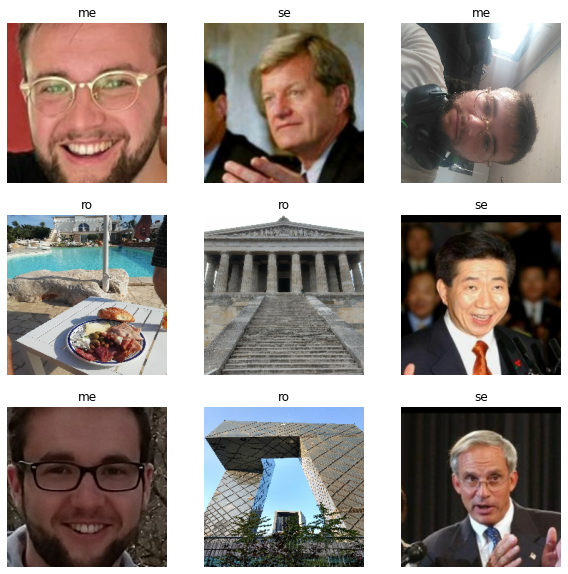

In [59]:
# visualize the data
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

TypeError: unsupported format string passed to list.__format__

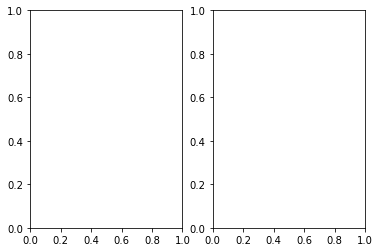

In [60]:
# show data distribution
amount_train_images = (amount_images_se_user_input + amount_images_me_user_input + amount_images_ro_user_input) * (1 - VALIDATION_SPLIT) + 1 # files used for trainig gets alway rounded up
amount_validation_images = (amount_images_se_user_input + amount_images_me_user_input + amount_images_ro_user_input) * VALIDATION_SPLIT

dataset_distribution = [amount_train_images, amount_validation_images]
dataset_distribution_labels = ["Training Set", "Validation Set"]
test_distribution = [tf.data.experimental.cardinality(validation_dataset), tf.data.experimental.cardinality(test_dataset)]
testDistributionLabels = ["# Validation Batches", "# Test Batches"]

def autopct(values):
    return '{:.0f} / {:,.0f}%'.format(values, values)

fig, axs = plt.subplots(1, 2)

axs[0].pie(dataset_distribution, labels=dataset_distribution_labels, radius=2, wedgeprops={"linewidth": 2, "edgecolor": "white"}, frame=False, autopct=autopct(dataset_distribution))
axs[1].pie(test_distribution, labels=testDistributionLabels, radius=2, wedgeprops={"linewidth": 2, "edgecolor": "white"}, frame=False, autopct='%.d')
axs[0].set_title("Training/Validation Split")
axs[1].set_title("Validation/Test Split")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=2, 
                    top=2, 
                    wspace=2, 
                    hspace=2)
plt.show()

#### Preprocess the data
First of all the dataset is configured for better performance by using the prefetching method. Prefetching overlaps opening, reading and training during the execution of a model. While the training is executed the input pipeline is reading the the data for the next training step. <cite id="ijgfh"><a href="#zotero%7C12668441%2FTCJXDMGP">(<i>Better Performance with the Tf.Data API | TensorFlow Core</i>, n.d.)</a></cite> 

# Herausfinden wie viel Unterschied Prefetching macht

To fit the data for putting it into a neural network it needs to be standardized. This means the image size is fixed for the whole dataset. This step is already done in the ['Create Dataset'](#create-dataset)-section. Additionally the pixel values must be normalized from RGB-range (0 - 255) to fit the pixel space the network expects. In this case the range is between -1 and 1. <cite id="kj5s4"><a href="#zotero%7C12668441%2FMVDHUU4A">(<i>Transfer Learning and Fine-Tuning | TensorFlow Core</i>, n.d.)</a></cite>

Data augmentation is a technique to increase the diversification of a data set when using a small data set. For this purpose, the training set is transformed randomly but realistically. <cite id="p8s8c"><a href="#zotero%7C12668441%2FK8WZ388C">(<i>Data Augmentation | TensorFlow Core</i>, n.d.)</a></cite>

In [61]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Normalize and rescale the data
preprocess_inputMobileNetV2 = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_inputXception = tf.keras.applications.xception.preprocess_input
rescale = tf.keras.layers.Rescaling(1. / 127.5, offset=-1)

# print batch tensor shape for validation
image_batch, labels_batch = next(iter(train_dataset))
print(f"Shape of batches: {image_batch.shape}")

# apply data augmentation
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Shape of batches: (16, 224, 224, 3)


#### Have a look at the data again
To visualize the effects of the data augmentation an example image is shown after being processed.

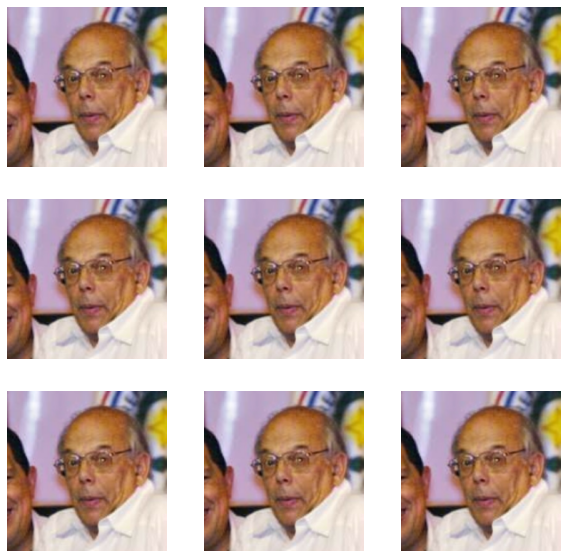

In [63]:
# visualize data augmentation
plt.figure(figsize=(10, 10))
for image, _ in train_dataset.take(1):    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(image)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')


# Network Training

### Transfer Learning
A common approach to do image classification tasks with deep neural networks is transfer learning. For transfer learning a pre-trained model is used as the base of the neural network. Then the model is adapted and fine-tuned to work on the specific task. The biggest advantage of transfer learning in image classification is that it can be applied to smaller datasets and the model trains faster. <cite id="wolwk"><a href="#zotero%7C12668441%2FQSWZ8C7A">(Trofimov &#38; Bogatyreva, 2020)</a></cite> 

The Keras framework provides a variety of available pre-trained models usable for transfer learning. In the following, two suitable models will be determined and subsequently trained. The results of the training will then be analyzed and discussed. The table below shows the models to choose from. Where the top-1 and top-5 accuracy was determined based on the performance of the model based on the [ImageNet](https://www.image-net.org/index.php) dataset. The value for the depth of the network is composed of the number of activation layers, batch normalization layers etc. Time per inference step is the average of 30 batches and 10 repetitions on the hardware used by Keras and varies on every machine. <cite id="13st3"><a href="#zotero%7C12668441%2F3KVIW22P">(Keras Team, n.d.)</a></cite>

| Model             | Size (MB) | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth | Time (ms) per inference step (CPU) | Time (ms) per inference step (GPU) |
|-------------------|-----------|----------------|----------------|------------|-------|------------------------------------|------------------------------------|
| Xception          | 88        | 79.0%          | 94.5%          | 22.9M      | 81    | 109.4                              | 8.1                                |
| VGG16             | 528       | 71.3%          | 90.1%          | 138.4M     | 16    | 69.5                               | 4.2                                |
| VGG19             | 549       | 71.3%          | 90.0%          | 143.7M     | 19    | 84.8                               | 4.4                                |
| ResNet50          | 98        | 74.9%          | 92.1%          | 25.6M      | 107   | 58.2                               | 4.6                                |
| ResNet50V2        | 98        | 76.0%          | 93.0%          | 25.6M      | 103   | 45.6                               | 4.4                                |
| ResNet101         | 171       | 76.4%          | 92.8%          | 44.7M      | 209   | 89.6                               | 5.2                                |
| ResNet101V2       | 171       | 77.2%          | 93.8%          | 44.7M      | 205   | 72.7                               | 5.4                                |
| ResNet152         | 232       | 76.6%          | 93.1%          | 60.4M      | 311   | 127.4                              | 6.5                                |
| ResNet152V2       | 232       | 78.0%          | 94.2%          | 60.4M      | 307   | 107.5                              | 6.6                                |
| InceptionV3       | 92        | 77.9%          | 93.7%          | 23.9M      | 189   | 42.2                               | 6.9                                |
| InceptionResNetV2 | 215       | 80.3%          | 95.3%          | 55.9M      | 449   | 130.2                              | 10.0                               |
| MobileNet         | 16        | 70.4%          | 89.5%          | 4.3M       | 55    | 22.6                               | 3.4                                |
| MobileNetV2       | 14        | 71.3%          | 90.1%          | 3.5M       | 105   | 25.9                               | 3.8                                |
| DenseNet121       | 33        | 75.0%          | 92.3%          | 8.1M       | 242   | 77.1                               | 5.4                                |
| DenseNet169       | 57        | 76.2%          | 93.2%          | 14.3M      | 338   | 96.4                               | 6.3                                |
| DenseNet201       | 80        | 77.3%          | 93.6%          | 20.2M      | 402   | 127.2                              | 6.7                                |
| NASNetMobile      | 23        | 74.4%          | 91.9%          | 5.3M       | 389   | 27.0                               | 6.7                                |
| NASNetLarge       | 343       | 82.5%          | 96.0%          | 88.9M      | 533   | 344.5                              | 20.0                               |
| EfficientNetB0    | 29        | 77.1%          | 93.3%          | 5.3M       | 132   | 46.0                               | 4.9                                |
| EfficientNetB1    | 31        | 79.1%          | 94.4%          | 7.9M       | 186   | 60.2                               | 5.6                                |
| EfficientNetB2    | 36        | 80.1%          | 94.9%          | 9.2M       | 186   | 80.8                               | 6.5                                |
| EfficientNetB3    | 48        | 81.6%          | 95.7%          | 12.3M      | 210   | 140.0                              | 8.8                                |
| EfficientNetB4    | 75        | 82.9%          | 96.4%          | 19.5M      | 258   | 308.3                              | 15.1                               |
| EfficientNetB5    | 118       | 83.6%          | 96.7%          | 30.6M      | 312   | 579.2                              | 25.3                               |
| EfficientNetB6    | 166       | 84.0%          | 96.8%          | 43.3M      | 360   | 958.1                              | 40.4                               |
| EfficientNetB7    | 256       | 84.3%          | 97.0%          | 66.7M      | 438   | 1578.9                             | 61.6                               |
| EfficientNetV2B0  | 29        | 78.7%          | 94.3%          | 7.2M       | -     | -                                  | -                                  |
| EfficientNetV2B1  | 34        | 79.8%          | 95.0%          | 8.2M       | -     | -                                  | -                                  |
| EfficientNetV2B2  | 42        | 80.5%          | 95.1%          | 10.2M      | -     | -                                  | -                                  |
| EfficientNetV2B3  | 59        | 82.0%          | 95.8%          | 14.5M      | -     | -                                  | -                                  |
| EfficientNetV2S   | 88        | 83.9%          | 96.7%          | 21.6M      | -     | -                                  | -                                  |
| EfficientNetV2M   | 220       | 85.3%          | 97.4%          | 54.4M      | -     | -                                  | -                                  |
| EfficientNetV2L   | 479       | 85.7%          | 97.5%          | 119.0M     | -     | -                                  | -                                  |

<div align="center">Table: Models available in Keras. <cite id="d52is"><a href="#zotero%7C12668441%2F3KVIW22P">(Keras Team, n.d.)</a></cite></div>
<br />
The table shows that the time required for an inference step is directly related to the number of parameters and the depth of the network. In order to find the right network for the respective application, the available hardware should be taken into account and, depending on the hardware, networks with few parameters or less depth should be used for faster training. 

Accuracy should also be taken into account. A distinction should be made between top-1 and top-5 accuracy. The top-1 accuracy is that the prediction of the model is exactly the expected answer. Top-5 accuracy means that the model determines the correct answer among the 5 highest probabilities of the network prediction. <cite id="9nj56"><a href="#zotero%7C12668441%2FHSDR2DAU">(Dang, 2021)</a></cite> 

Since a strong graphics card, the [Nvidia GeForce RTX 3070](https://www.nvidia.com/de-de/geforce/graphics-cards/30-series/rtx-3070-3070ti/), is available for training, a computationally more intensive model will be trained. In addition, the model should have a high top-1 accuracy, since it should distinguish exactly between my face and other faces or objects. For comparison, a model with lower hardware requirements is trained. 

#### Transfer learning workflow
A common transfer learning approach is to freeze the layers of the pre-trained model. That means the weights of the base model won't be updated to avoid trainig the model from scratch. Next there are new layers added on top of the forzen layers which are trainable. These layers are necessary to turn the features of the pre-trained model into predictions of the new dataset. Then the model is trained. Optionally the model can be fine-tuned by making all the layers trainable and and adapting them to the new data. <cite id="3in4f"><a href="#zotero%7C12668441%2FMVDHUU4A">(<i>Transfer Learning and Fine-Tuning | TensorFlow Core</i>, n.d.)</a></cite>
This transfer learning workflow is shown for both base models below.

In [64]:
# define hyperparameters
initial_epochs = 100
base_learningRate = 0.001

# Create the base model from the pre-trained model MobileNet V2
img_size = (224, 224)
img_shape = img_size + (3,)
print(f"Image shape: {img_shape}")
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                              include_top=False,
                                              weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(f"Feature batch shape: {feature_batch.shape}")

# freeze the convolutional base
base_model.trainable = False

# show model
# base_model.summary()
sum_classes = len(class_names)
print(f"Sum of classes: {sum_classes}")

inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)
x = preprocess_inputMobileNetV2(x)
x = rescale(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)
x = tf.keras.layers.Dense(units=16)(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)
outputs = tf.keras.layers.Dense(sum_classes, activation='softmax')(x)
mobileNetV2_model = tf.keras.Model(inputs, outputs)

mobileNetV2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learningRate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mobileNetV2_model.summary()

Image shape: (224, 224, 3)
Feature batch shape: (16, 7, 7, 1280)
Sum of classes: 3
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                          

In [65]:
# define hyperparameters
initial_epochs = 20
base_learningRate = 0.0001

# Create the base model from the pre-trained model Xception
img_size = (224, 224)
img_shape = img_size + (3,)
print(img_shape)
base_model = tf.keras.applications.Xception(input_shape=img_shape,
                                              include_top=False, 
                                              weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# freeze the convolutional base
base_model.trainable = False

inputs = tf.keras.Input(shape=img_shape)
x = preprocess_inputXception(x)
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
outputs = tf.keras.layers.Dense(sum_classes, activation='softmax')(x)
xception_model = tf.keras.Model(inputs, outputs)

xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learningRate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

xception_model.summary()

(224, 224, 3)
(16, 7, 7, 2048)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                            

### Callbacks

In [66]:
checkpoint_filepath_xception = "checkpoints/xception"
checkpoint_filepath_mobileNetV2 = "checkpoints/mobileNetV2"

xception_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_xception,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

mobileNetV2_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_mobileNetV2,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [67]:
xception_history = xception_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=xception_callback)

Epoch 1/20


c:\Users\RicoSteinke\.conda\envs\dl\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


53/53 [==============================] - 6s 79ms/step - loss: 1.3536 - accuracy: 0.4773 - val_loss: 0.9698 - val_accuracy: 0.5141
Epoch 2/20
53/53 [==============================] - 2s 46ms/step - loss: 0.7992 - accuracy: 0.6675 - val_loss: 0.5883 - val_accuracy: 0.7401
Epoch 3/20
53/53 [==============================] - 2s 46ms/step - loss: 0.5300 - accuracy: 0.7967 - val_loss: 0.4130 - val_accuracy: 0.8588
Epoch 4/20
53/53 [==============================] - 2s 46ms/step - loss: 0.4014 - accuracy: 0.8505 - val_loss: 0.3180 - val_accuracy: 0.9096
Epoch 5/20
53/53 [==============================] - 2s 46ms/step - loss: 0.3565 - accuracy: 0.8672 - val_loss: 0.2586 - val_accuracy: 0.9153
Epoch 6/20
53/53 [==============================] - 2s 46ms/step - loss: 0.2674 - accuracy: 0.9067 - val_loss: 0.2207 - val_accuracy: 0.9209
Epoch 7/20
53/53 [==============================] - 2s 42ms/step - loss: 0.2096 - accuracy: 0.9282 - val_loss: 0.1978 - val_accuracy: 0.9209
Epoch 8/20
53/53 [======

In [68]:
mobileNetV2_history = mobileNetV2_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
53/53 [==============================] - 4s 35ms/step - loss: 1.1223 - accuracy: 0.4522 - val_loss: 0.9885 - val_accuracy: 0.5706
Epoch 2/20
53/53 [==============================] - 1s 21ms/step - loss: 1.0069 - accuracy: 0.5036 - val_loss: 0.9053 - val_accuracy: 0.6949
Epoch 3/20
53/53 [==============================] - 1s 21ms/step - loss: 0.9284 - accuracy: 0.5634 - val_loss: 0.8085 - val_accuracy: 0.7175
Epoch 4/20
53/53 [==============================] - 1s 21ms/step - loss: 0.8866 - accuracy: 0.6041 - val_loss: 0.7097 - val_accuracy: 0.7006
Epoch 5/20
53/53 [==============================] - 1s 21ms/step - loss: 0.8224 - accuracy: 0.6423 - val_loss: 0.6634 - val_accuracy: 0.7288
Epoch 6/20
53/53 [==============================] - 1s 21ms/step - loss: 0.7676 - accuracy: 0.6591 - val_loss: 0.6190 - val_accuracy: 0.7345
Epoch 7/20
53/53 [==============================] - 1s 21ms/step - loss: 0.7473 - accuracy: 0.6938 - val_loss: 0.5899 - val_accuracy: 0.7571
Epoch 8/20
53

### Fine-tuning

# Evaluation

Grad-CAM class activation visualization

Vergleichen mit OpenCV zugeschnitten

In [69]:
def plot_history(model_learning, label, save_fig = True):
    # Basic plot configuration
    fig = plt.figure(figsize=(15,5))
    fig.suptitle('Training history: ' + label, fontsize=16, y=1.01, fontweight='bold')
    # Loss
    plt.subplot(121)
    plt.plot(model_learning.history['loss'], label='train loss')
    plt.plot(model_learning.history['val_loss'], label='val loss')
    plt.ylim(0,1.0)
    plt.legend()
    # Accuracies
    plt.subplot(122)
    plt.plot(model_learning.history['accuracy'], label='train accuracy')
    plt.plot(model_learning.history['val_accuracy'], label='val accuracy')
    plt.ylim(0,1.15)
    plt.legend()
    plt.show()

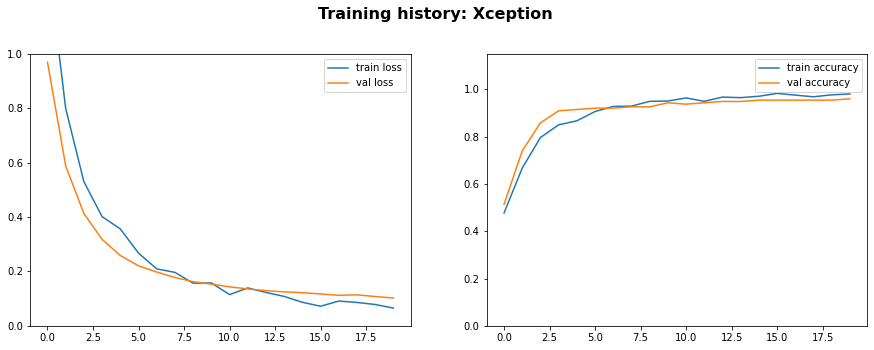

In [70]:
# Plot the training history: Xception
plot_history(xception_history, 'Xception', save_fig = False)

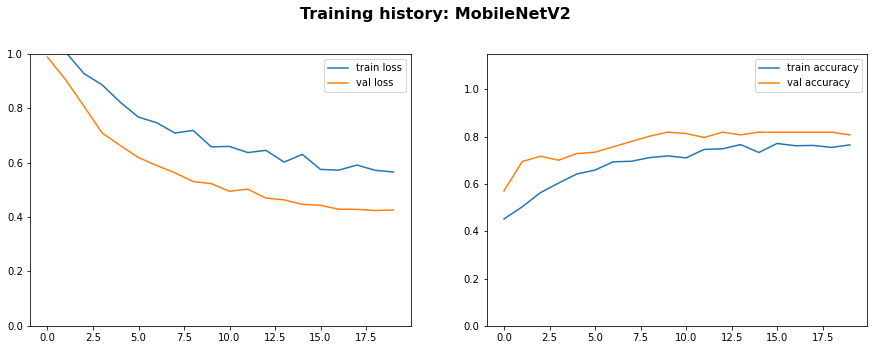

In [71]:
# Plot the training history: MobileNetV2
plot_history(mobileNetV2_history, 'MobileNetV2', save_fig = False)

# Confusion matrices


In [115]:
# Generate a confusion matrix for a defined model and dataset
def get_confusion_matrix(model, dataset):
    print("Generating confusion matrix")
    predictions = []
    targets = []
    i = 0
    for image_batch, label_batch in dataset: 
        targets.append(label_batch)
        pred = model.predict(image_batch)
        predictions.append(np.argmax(pred, axis= -1))
            
    labels = tf.concat([item for item in targets], axis=0)
    pred_labels = tf.concat([item for item in predictions], axis=0)
    
    cm = tf.math.confusion_matrix(
    labels,
    pred_labels)
    return cm

# Plot a tensorflow confusion matrix using seaborn heatmap
def show_confusion_matrix(cm):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('True Label')
  plt.show()

32
Generating confusion matrix 32
1/1 [==============================] - 0s 23ms/step


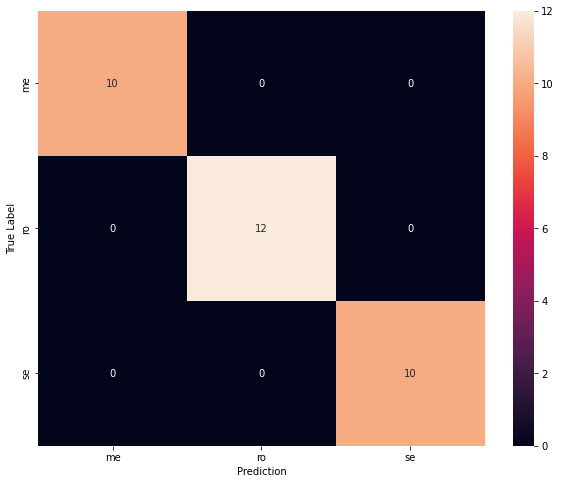

In [116]:
# Get amount of images used for testing
test_dataset_files = len(np.concatenate([i for x, i in test_dataset], axis=0))
print(f"Sum of images used for testing: {test_dataset_files}")

# Plot confusion matrix
xception_confusion_matrix = get_confusion_matrix(xception_model, test_dataset)
show_confusion_matrix(xception_confusion_matrix)

# Testing

In [74]:
# Evaluate a model with the test dataset and print testing loss and testing accuracy
def model_testing(model, test_dataset):
    loss, acc = model.evaluate(test_dataset)
    print("-------------------------------------------------")
    print(f"Testing loss: {loss}")
    print(f"Testing accuracy: {acc}")
    print("-------------------------------------------------")

In [75]:
print("Testing MobileNetV2")
model_testing(mobileNetV2_model, test_dataset)
print("Testing Xception")
model_testing(xception_model, test_dataset)

Testing MobileNetV2
2/2 [==============================] - 0s 38ms/step - loss: 0.4928 - accuracy: 0.7812
-------------------------------------------------
Testing loss: 0.4927515983581543
Testing accuracy: 0.78125
-------------------------------------------------
Testing Xception
2/2 [==============================] - 0s 34ms/step - loss: 0.0959 - accuracy: 0.9688
-------------------------------------------------
Testing loss: 0.0958644226193428
Testing accuracy: 0.96875
-------------------------------------------------


# Discussion of the results

# Bibliography
<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|12668441/TCJXDMGP"></i><i>Better performance with the tf.data API | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved July 10, 2022, from <a href="https://www.tensorflow.org/guide/data_performance">https://www.tensorflow.org/guide/data_performance</a></div>
  <div class="csl-entry"><i id="zotero|12668441/EXM36PCP"></i>Bradski, G. (2000). The OpenCV Library. <i>Dr. Dobb’s Journal of Software Tools</i>.</div>
  <div class="csl-entry"><i id="zotero|12668441/HSDR2DAU"></i>Dang, A. T. (2021, January 7). <i>Accuracy and Loss: Things to Know about The Top 1 and Top 5 Accuracy</i>. Medium. <a href="https://towardsdatascience.com/accuracy-and-loss-things-to-know-about-the-top-1-and-top-5-accuracy-1d6beb8f6df3">https://towardsdatascience.com/accuracy-and-loss-things-to-know-about-the-top-1-and-top-5-accuracy-1d6beb8f6df3</a></div>
  <div class="csl-entry"><i id="zotero|12668441/K8WZ388C"></i><i>Data augmentation | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved June 19, 2022, from <a href="https://www.tensorflow.org/tutorials/images/data_augmentation">https://www.tensorflow.org/tutorials/images/data_augmentation</a></div>
  <div class="csl-entry"><i id="zotero|12668441/AN5HZ4B7"></i>Huang, G. B., Ramesh, M., Berg, T., &#38; Learned-Miller, E. (2007). <i>Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments</i> (No. 07–49). University of Massachusetts, Amherst. <a href="http://vis-www.cs.umass.edu/lfw/index.html">http://vis-www.cs.umass.edu/lfw/index.html</a></div>
  <div class="csl-entry"><i id="zotero|12668441/3KVIW22P"></i>Keras Team. (n.d.). <i>Keras documentation: Keras Applications</i>. Retrieved July 13, 2022, from <a href="https://keras.io/api/applications/">https://keras.io/api/applications/</a></div>
  <div class="csl-entry"><i id="zotero|12668441/DW3K5WQH"></i><i>Load and preprocess images | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved June 19, 2022, from <a href="https://www.tensorflow.org/tutorials/load_data/images">https://www.tensorflow.org/tutorials/load_data/images</a></div>
  <div class="csl-entry"><i id="zotero|12668441/MVDHUU4A"></i><i>Transfer learning and fine-tuning | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved July 14, 2022, from <a href="https://www.tensorflow.org/guide/keras/transfer_learning">https://www.tensorflow.org/guide/keras/transfer_learning</a></div>
  <div class="csl-entry"><i id="zotero|12668441/QSWZ8C7A"></i>Trofimov, A. G., &#38; Bogatyreva, A. A. (2020). A Method of Choosing a Pre-trained Convolutional Neural Network for Transfer Learning in Image Classification Problems. In B. Kryzhanovsky, W. Dunin-Barkowski, V. Redko, &#38; Y. Tiumentsev (Eds.), <i>Advances in Neural Computation, Machine Learning, and Cognitive Research III</i> (Vol. 856, pp. 263–270). Springer International Publishing. <a href="https://doi.org/10.1007/978-3-030-30425-6_31">https://doi.org/10.1007/978-3-030-30425-6_31</a></div>
</div>
<!-- BIBLIOGRAPHY END -->